
# Transfer learning


Задача: необходимо построить модель с использованием Transfer learning, которая будет давать лучшее accuracy на тестовом наборе данных. Распознование 3 видов изображений: пицца, суши, мясо.

# Загрузка данных

In [ ]:
import requests
import zipfile
from pathlib import Path

# укажем куда загружать данные
data_path = Path("data/")
image_path = data_path / "images"

# Проверяем, создана ли директория
if image_path.is_dir():
    print(f"Директория {image_path} существует.")
else:
    print(f"Директория {image_path} отстутствует, создаем...")
image_path.mkdir(parents=True, exist_ok=True)

# Скачиваем архив с данными
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/obulygin/content/raw/main/pizza_stake_sushi/pizza_steak_sushi.zip")
    print("Скачиваем данные")
    f.write(request.content)

# Разархивируем данные
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Разархивируем данные")
    zip_ref.extractall(image_path)

Директория data/images отстутствует, создаем...
Скачиваем данные
Разархивируем данные


In [ ]:
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/images/train'), PosixPath('data/images/test'))

Изображение: data/images/train/steak/231296.jpg
Класс изображения: steak
Высота изображения: 382
Ширина изображения: 512


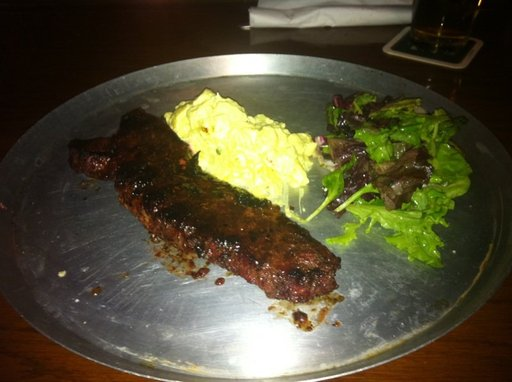

In [ ]:
import random
from PIL import Image

random.seed(40)

# Получаем список всех файлов с расширением .jpg
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Получаем случайный файл
random_image_path = random.choice(image_path_list)

# Получаем класс случайного изображения (соответствует папке)
image_class = random_image_path.parent.stem

# Открываем изображение
img = Image.open(random_image_path)

# Выводим данные по картине
print(f"Изображение: {random_image_path}")
print(f"Класс изображения: {image_class}")
print(f"Высота изображения: {img.height}")
print(f"Ширина изображения: {img.width}")
img

In [ ]:
from torchvision import datasets, transforms, models
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch
import tqdm
import time

torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(244),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(244),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
train_data = datasets.ImageFolder(root=train_dir, # директория с фото
                                  transform=train_transform, # преобразование трейна
                                  target_transform=None) # преобразование таргета

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=test_transform,
                                 target_transform=None)

In [ ]:
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [ ]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:
print(len(train_data))
print(len(test_data))

225
75


In [ ]:
# в тренировочную выборку отнесем 80% всех картинок
train_size = int(len(train_data) * 0.80)
# в валидационную — остальные 20%
val_size = len(train_data) - train_size

train_data, val_data = torch.utils.data.random_split(train_data, [train_size, val_size], generator=torch.Generator().manual_seed(777))
print(f"Тренировочные данные:\n{train_data}\nВалидационные данные:\n{test_data}")

Тренировочные данные:
Валидационные данные:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/images/test
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(244, 244))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                              batch_size=16,
                              shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_data,
                             batch_size=16,
                             shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_data,
                             batch_size=16,
                             shuffle=False)

train_loader, val_loader, test_loader

(<torch.utils.data.dataloader.DataLoader at 0x7ca18ff622d0>,
 <torch.utils.data.dataloader.DataLoader at 0x7ca1905ba210>)

# Resnet18

In [ ]:
model = models.resnet18(weights=None)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [ ]:
model.fc = nn.Linear(512, 3)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
def train(model, train_loader, val_loader, loss_fn, optimizer, epochs):
    model.to(device)

    model.train()

    start_time = time.time()  # Запоминаем начало обучения

    for epoch in range(epochs):
        # итерируем по батчам на трейне
        for X_batch, y_batch in train_loader:
            # переводим батчи на GPU
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            # получаем предсказания модели для батча
            y_pred = model(X_batch)
            # вычисляем функцию потерь для батча
            loss = loss_fn(y_pred, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # вызываем функцию evaluate на валидации и получаем значения функции потерь и точности
        print(f'Эпоха {epoch+1}')
        val_loss, val_accuracy = evaluate(model, val_loader, loss_fn)

    end_time = time.time()  # Запоминаем конец обучения
    total_time = end_time - start_time
    print(f"\nОбщее время обучения: {total_time:.2f} секунд")

    return model, total_time

def evaluate(model, data_loader, loss_fn):
    total_loss = 0
    correct = 0
    model.to(device)
    # переводим модель в режим оценки
    model.eval()
    # включаем контекстный менеджер для инференса
    with torch.inference_mode():
        # итерируем по батчам
        for X, y in data_loader:
            # переводим батчи на GPU
            X, y = X.to(device), y.to(device)
            # делаем предсказания модели
            pred = model(X)
            # вычисляем функцию потерь
            loss = loss_fn(pred, y)
            # добавляем функцию потерь к суммарной
            total_loss += loss.item()
            # получаем индексы максимальных значений в предсказаниях модели
            pred = torch.argmax(pred, dim=1)
            # сравниваем предсказания модели с метками и считаем, сколько раз они совпадают
            correct += torch.sum(pred == y).item()

    # вычисляем среднюю функцию потерь по данным
    mean_loss = total_loss / len(data_loader)
    # вычисляем точность по данным
    accuracy = correct / len(data_loader.dataset)

    print(f"Функция потерь (кросс-энтропия) на данных {mean_loss}")
    print(f"Точность на данных {accuracy}")

    return mean_loss, accuracy

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

trained_model, trained_time = train(model, train_loader, val_loader, loss_fn, optimizer, epochs=10)

In [ ]:
trained_model_mean_loss, trained_model_accuracy = evaluate(trained_model, val_loader, loss_fn)

Функция потерь (кросс-энтропия) на данных 1.0482219854990642
Точность на данных 0.4888888888888889


In [ ]:
#Датафрейм для хранения результатов
mod = pd.DataFrame(columns=["Модель сети", "Accuracy на валидации", 'Время обучения'])

# Добавляем строку с результатами
mod.loc[len(mod)] = ["resnet18(weights=None)", trained_model_accuracy, trained_time]

In [ ]:
mod

,Модель сети,Accuracy на валидации,Время обучения
0,resnet18(weights=None),0.488889,445.248968


In [ ]:
# Сохраняем модель
# --- Создаем директорию для моделей (если ее нет) ---
MODEL_PATH = Path("models")
#MODEL_PATH.mkdir(parents=True, # Создать родительские директории, если нужно
#                 exist_ok=True) # Не вызывать ошибку, если директория уже существует

# --- Определяем имя файла для сохранения ---
MODEL_NAME = "0_pytorch_resnet18_no_wieghts.pth" # Используем расширение .pth или .pt
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"\nСохраняем state_dict модели в: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), # Сохраняем  state_dict
           f=MODEL_SAVE_PATH)
print("Модель сохранена.")


Сохраняем state_dict модели в: models/0_pytorch_resnet18_no_wieghts.pth
Модель сохранена.


## Feature Extractor

In [ ]:
#модель с предобученными весами
model_1 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
#можно еще так
#model = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 207MB/s]


In [ ]:
len(list(model.children()))

10

In [ ]:
def create_model(model, num_freeze_layers, num_out_classes):
    # замена последнего слоя сети
    model.fc = nn.Linear(512, num_out_classes)

    # заморозка слоев
    for i, layer in enumerate(model.children()):
        if i <= num_freeze_layers:
            for param in layer.parameters():
                param.requires_grad = False

    return model

In [ ]:
model_1 = create_model(models.resnet18(weights=models.ResNet18_Weights.DEFAULT), 8, 3)
model_1

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
optimizer_1 = torch.optim.Adam(model_1.parameters(), lr=1e-3)
trained_model_1, trained_time_1 = train(model_1, train_loader, val_loader, loss_fn, optimizer_1, epochs=10)

Эпоха 1
Функция потерь (кросс-энтропия) на данных 0.9394340316454569
Точность на данных 0.5111111111111111
Эпоха 2
Функция потерь (кросс-энтропия) на данных 0.8162074486414591
Точность на данных 0.7111111111111111
Эпоха 3
Функция потерь (кросс-энтропия) на данных 0.7012412349383036
Точность на данных 0.7333333333333333
Эпоха 4
Функция потерь (кросс-энтропия) на данных 0.543017566204071
Точность на данных 0.8666666666666667
Эпоха 5
Функция потерь (кросс-энтропия) на данных 0.535213698943456
Точность на данных 0.8
Эпоха 6
Функция потерь (кросс-энтропия) на данных 0.45453545451164246
Точность на данных 0.8444444444444444
Эпоха 7
Функция потерь (кросс-энтропия) на данных 0.4691578149795532
Точность на данных 0.8222222222222222
Эпоха 8
Функция потерь (кросс-энтропия) на данных 0.45300373435020447
Точность на данных 0.8888888888888888
Эпоха 9
Функция потерь (кросс-энтропия) на данных 0.42843323945999146
Точность на данных 0.8888888888888888
Эпоха 10
Функция потерь (кросс-энтропия) на данных 

In [ ]:
trained_model_mean_loss_1, trained_model_accuracy_1 = evaluate(trained_model_1, val_loader, loss_fn)

Функция потерь (кросс-энтропия) на данных 0.4566283126672109
Точность на данных 0.8666666666666667


In [ ]:
import torchvision.models as tv_models

In [ ]:
# Добавляем строку с результатами
mod.loc[len(mod)] = ["1_resnet18(Weights.DEFAULT), 8", trained_model_accuracy_1, trained_time_1]
mod

,Модель сети,Accuracy на валидации,Время обучения
0,resnet18(weights=None),0.488889,445.248968
1,"1_resnet18(Weights.DEFAULT), 8",0.866667,181.498203


In [ ]:
# --- Определяем имя файла для сохранения ---
MODEL_NAME = "pytorch_resnet18_wieghts_frozen8.pth" # Используем расширение .pth или .pt
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"\nСохраняем state_dict модели в: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), # Сохраняем  state_dict
           f=MODEL_SAVE_PATH)
print("Модель сохранена.")


Сохраняем state_dict модели в: models/pytorch_resnet18_wieghts_frozen8.pth
Модель сохранена.


# AlexNet

In [ ]:
from torchvision import models

In [ ]:
model_2 = models.alexnet(weights=None)
model_2

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 4096
# Заменяем Fully-Connected слой на наш линейный классификатор
model_2.classifier[6] = nn.Linear(num_features, 3)

In [ ]:
optimizer_2 = torch.optim.Adam(model_2.parameters(), lr=1e-3)
trained_model_2, trained_time_2 = train(model_2, train_loader, val_loader, loss_fn, optimizer_2, epochs=10)

Эпоха 1
Функция потерь (кросс-энтропия) на данных 1.0622765223185222
Точность на данных 0.37777777777777777
Эпоха 2
Функция потерь (кросс-энтропия) на данных 1.1103444496790569
Точность на данных 0.28888888888888886
Эпоха 3
Функция потерь (кросс-энтропия) на данных 1.1264551877975464
Точность на данных 0.35555555555555557
Эпоха 4
Функция потерь (кросс-энтропия) на данных 1.1690474549929302
Точность на данных 0.4444444444444444
Эпоха 5
Функция потерь (кросс-энтропия) на данных 1.169003466765086
Точность на данных 0.37777777777777777
Эпоха 6
Функция потерь (кросс-энтропия) на данных 1.0331294139226277
Точность на данных 0.4666666666666667
Эпоха 7
Функция потерь (кросс-энтропия) на данных 1.1162923574447632
Точность на данных 0.4
Эпоха 8
Функция потерь (кросс-энтропия) на данных 1.1905008554458618
Точность на данных 0.37777777777777777
Эпоха 9
Функция потерь (кросс-энтропия) на данных 1.1594765186309814
Точность на данных 0.35555555555555557
Эпоха 10
Функция потерь (кросс-энтропия) на дан

In [ ]:
trained_model_mean_loss_2, trained_model_accuracy_2 = evaluate(trained_model_2, val_loader, loss_fn)

Функция потерь (кросс-энтропия) на данных 1.0677025318145752
Точность на данных 0.4444444444444444


In [ ]:
# Добавляем строку с результатами
mod.loc[len(mod)] = ["2_alexnet(weights=None)", trained_model_accuracy_2, trained_time_2]

In [ ]:
mod

,Модель сети,Accuracy на валидации,Время обучения
0,resnet18(weights=None),0.488889,445.248968
1,"1_resnet18(Weights.DEFAULT), 8",0.866667,181.498203
2,2_alexnet(weights=None),0.444444,206.963556


In [ ]:
# --- Определяем имя файла для сохранения ---
MODEL_NAME = "2_pytorch_alexnet_no_weights.pth" # Используем расширение .pth или .pt
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"\nСохраняем state_dict модели в: {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(), # Сохраняем  state_dict
           f=MODEL_SAVE_PATH)
print("Модель сохранена.")


Сохраняем state_dict модели в: models/2_pytorch_alexnet_no_weights.pth
Модель сохранена.


##Fine Tuning

In [ ]:
model_3 = models.alexnet(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 156MB/s]


In [ ]:
# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 4096
# Заменяем Fully-Connected слой на наш линейный классификатор
model_3.classifier[6] = nn.Linear(num_features, 3)

optimizer_3 = torch.optim.Adam(model_3.parameters(), lr=1e-3)

In [ ]:
trained_model_3, trained_time_3 = train(model_3, train_loader, val_loader, loss_fn, optimizer_3, epochs=10)

Эпоха 1
Функция потерь (кросс-энтропия) на данных 1.1131008863449097
Точность на данных 0.37777777777777777
Эпоха 2
Функция потерь (кросс-энтропия) на данных 1.112105131149292
Точность на данных 0.28888888888888886
Эпоха 3
Функция потерь (кросс-энтропия) на данных 1.111267884572347
Точность на данных 0.28888888888888886
Эпоха 4
Функция потерь (кросс-энтропия) на данных 1.1032439072926838
Точность на данных 0.37777777777777777
Эпоха 5
Функция потерь (кросс-энтропия) на данных 1.097741921742757
Точность на данных 0.37777777777777777
Эпоха 6
Функция потерь (кросс-энтропия) на данных 1.1016989946365356
Точность на данных 0.28888888888888886
Эпоха 7
Функция потерь (кросс-энтропия) на данных 1.102455496788025
Точность на данных 0.28888888888888886
Эпоха 8
Функция потерь (кросс-энтропия) на данных 1.1048486630121868
Точность на данных 0.28888888888888886
Эпоха 9
Функция потерь (кросс-энтропия) на данных 1.099202036857605
Точность на данных 0.3333333333333333
Эпоха 10
Функция потерь (кросс-энт

In [ ]:
trained_model_mean_loss_3, trained_model_accuracy_3 = evaluate(trained_model_3, val_loader, loss_fn)

Функция потерь (кросс-энтропия) на данных 1.1125702857971191
Точность на данных 0.28888888888888886


In [ ]:
# Добавляем строку с результатами
mod.loc[len(mod)] = ["3_alexnet(pretrained=True), nn.Linear(3)", trained_model_accuracy_3, trained_time_3]
mod

,Модель сети,Accuracy на валидации,Время обучения
0,resnet18(weights=None),0.488889,445.248968
1,"1_resnet18(Weights.DEFAULT), 8",0.866667,181.498203
2,2_alexnet(weights=None),0.444444,206.963556
3,"3_alexnet(pretrained=True), nn.Linear(3)",0.288889,223.929965


In [ ]:
# --- Определяем имя файла для сохранения ---
MODEL_NAME = "3_pytorch_resnet18_all_wieghts.pth" # Используем расширение .pth или .pt
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"\nСохраняем state_dict модели в: {MODEL_SAVE_PATH}")
torch.save(obj=model_3.state_dict(), # Сохраняем  state_dict
           f=MODEL_SAVE_PATH)
print("Модель сохранена.")


Сохраняем state_dict модели в: models/3_pytorch_resnet18_all_wieghts.pth
Модель сохранена.


##Feature Extractor

### 1 способ

In [ ]:
#модель с предобученными весами
model_4 = models.alexnet(pretrained=True)
#можно еще так
#model = models.resnet18(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 164MB/s]


In [ ]:
# замораживаем параметры (веса)
for param in model_4.parameters():
    param.requires_grad = False

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 4096
# Заменяем Fully-Connected слой на наш линейный классификатор
model_4.classifier[6] = nn.Linear(num_features, 3)

In [ ]:
optimizer_4 = torch.optim.Adam(model_4.classifier[6].parameters(), lr=1e-3)

trained_model_4, trained_time_4 = train(model_4, train_loader, val_loader, loss_fn, optimizer_4, epochs=10)

Эпоха 1
Функция потерь (кросс-энтропия) на данных 0.4002622465292613
Точность на данных 0.8666666666666667
Эпоха 2
Функция потерь (кросс-энтропия) на данных 0.4420388340950012
Точность на данных 0.8444444444444444
Эпоха 3
Функция потерь (кросс-энтропия) на данных 0.3830225219329198
Точность на данных 0.8666666666666667
Эпоха 4
Функция потерь (кросс-энтропия) на данных 0.2782312234242757
Точность на данных 0.8222222222222222
Эпоха 5
Функция потерь (кросс-энтропия) на данных 0.29349385201931
Точность на данных 0.8888888888888888
Эпоха 6
Функция потерь (кросс-энтропия) на данных 0.4095752239227295
Точность на данных 0.8222222222222222
Эпоха 7
Функция потерь (кросс-энтропия) на данных 0.34089640776316327
Точность на данных 0.8666666666666667
Эпоха 8
Функция потерь (кросс-энтропия) на данных 0.3798690736293793
Точность на данных 0.8888888888888888
Эпоха 9
Функция потерь (кросс-энтропия) на данных 0.210877925157547
Точность на данных 0.9555555555555556
Эпоха 10
Функция потерь (кросс-энтропия

In [ ]:
trained_model_mean_loss_4, trained_model_accuracy_4 = evaluate(trained_model_4, val_loader, loss_fn)

Функция потерь (кросс-энтропия) на данных 0.24816785752773285
Точность на данных 0.9111111111111111


In [ ]:
# Добавляем строку с результатами
mod.loc[len(mod)] = ["4_alexnet(pretrained=True)+заморозка весов, nn.Linear(3)", trained_model_accuracy_4, trained_time_4]
mod

,Модель сети,Accuracy на валидации,Время обучения
0,resnet18(weights=None),0.488889,445.248968
1,"1_resnet18(Weights.DEFAULT), 8",0.866667,181.498203
2,2_alexnet(weights=None),0.444444,206.963556
3,"3_alexnet(pretrained=True), nn.Linear(3)",0.288889,223.929965
4,"4_alexnet(pretrained=True)+заморозка весов, nn...",0.933333,68.983065


In [ ]:
# --- Определяем имя файла для сохранения ---
MODEL_NAME = "4_pytorch_resnet18_all_wieghts_frozen.pth" # Используем расширение .pth или .pt
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"\nСохраняем state_dict модели в: {MODEL_SAVE_PATH}")
torch.save(obj=model_4.state_dict(), # Сохраняем  state_dict
           f=MODEL_SAVE_PATH)
print("Модель сохранена.")


Сохраняем state_dict модели в: models/4_pytorch_resnet18_all_wieghts_frozen.pth
Модель сохранена.


### 2 способ

In [ ]:
from torchvision import models

In [ ]:
#обучение не только последнего fully connected слой, но и несколько предпоследних
model_5 = models.alexnet(pretrained=True)

In [ ]:
model_5

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
#другой способ реализации, отличающийся от применения в resnet18
from itertools import chain

layers_to_unfreeze = 5

# Выключаем подсчет градиентов для слоев, которые не будем обучать
for param in model_5.features[:-layers_to_unfreeze].parameters():
    param.requires_grad = False

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 4096
# Заменяем Fully-Connected слой на наш линейный классификатор
model_5.classifier[6] = nn.Linear(num_features, 3)

# Обучаем последние layers_to_unfreeze слоев из сверточной части и fully connected слой
# parameters() возвращает просто список тензоров парамтеров, поэтому два таких списка можно сложить
optimizer_5 = torch.optim.Adam(
    chain(
        list(model_5.features.parameters())[-layers_to_unfreeze:],
        model_5.classifier.parameters()
    ),
    lr=1e-3,
)

In [ ]:
trained_model_5, trained_time_5 = train(model_5, train_loader, val_loader, loss_fn, optimizer_5, epochs=10)

Эпоха 1
Функция потерь (кросс-энтропия) на данных 0.8719491163889567
Точность на данных 0.5777777777777777
Эпоха 2
Функция потерь (кросс-энтропия) на данных 1.3780413468678792
Точность на данных 0.6222222222222222
Эпоха 3
Функция потерь (кросс-энтропия) на данных 0.5950591663519541
Точность на данных 0.6888888888888889
Эпоха 4
Функция потерь (кросс-энтропия) на данных 0.6475830475489298
Точность на данных 0.6444444444444445
Эпоха 5
Функция потерь (кросс-энтропия) на данных 0.6361859242121378
Точность на данных 0.8222222222222222
Эпоха 6
Функция потерь (кросс-энтропия) на данных 0.8255239129066467
Точность на данных 0.6444444444444445
Эпоха 7
Функция потерь (кросс-энтропия) на данных 1.5420661369959514
Точность на данных 0.5777777777777777
Эпоха 8
Функция потерь (кросс-энтропия) на данных 0.6065967877705892
Точность на данных 0.7777777777777778
Эпоха 9
Функция потерь (кросс-энтропия) на данных 0.8708138962586721
Точность на данных 0.7555555555555555
Эпоха 10
Функция потерь (кросс-энтроп

In [ ]:
trained_model_mean_loss_5, trained_model_accuracy_5 = evaluate(trained_model_5, val_loader, loss_fn)

Функция потерь (кросс-энтропия) на данных 0.667666107416153
Точность на данных 0.8444444444444444


In [ ]:
mod.loc[len(mod)] = ["5_alexnet(pretr.=True)+заморозка весов 5 слоев, nn.Linear(3)", trained_model_accuracy_5, trained_time_5]
mod

,Модель сети,Accuracy на валидации,Время обучения
0,resnet18(weights=None),0.488889,445.248968
1,"1_resnet18(Weights.DEFAULT), 8",0.866667,181.498203
2,2_alexnet(weights=None),0.444444,206.963556
3,"3_alexnet(pretrained=True), nn.Linear(3)",0.288889,223.929965
4,"4_alexnet(pretrained=True)+заморозка весов, nn...",0.933333,68.983065
5,5_alexnet(pretr.=True)+заморозка весов 5 слоев...,0.844444,173.920332


In [ ]:
# --- Определяем имя файла для сохранения ---
MODEL_NAME = "5_pytorch_resnet18_frozen5.pth" # Используем расширение .pth или .pt
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"\nСохраняем state_dict модели в: {MODEL_SAVE_PATH}")
torch.save(obj=model_5.state_dict(), # Сохраняем  state_dict
           f=MODEL_SAVE_PATH)
print("Модель сохранена.")


Сохраняем state_dict модели в: models/5_pytorch_resnet18_frozen5.pth
Модель сохранена.


###3 способ

In [ ]:
#Чтобы ядра в свертках сильно менялись во время обучения, а еще мы знаем, что чем меньше lr, тем меньше изменения.
#Уменьшим lr на feature extractor-е
model_6 = models.alexnet(pretrained=True)
model_6.classifier[6] = nn.Linear(num_features, 3)
optimizer_6 = torch.optim.Adam(
    (
        {
            "params": model_6.features.parameters(),
            "lr": 1e-6,
        },
        {
            "params": model_6.classifier.parameters(),
        }
     ),
     lr=1e-3
)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
trained_model_6, trained_time_6 = train(model_6, train_loader, val_loader, loss_fn, optimizer_6, epochs=10)

Эпоха 1
Функция потерь (кросс-энтропия) на данных 0.7912881424029669
Точность на данных 0.8222222222222222
Эпоха 2
Функция потерь (кросс-энтропия) на данных 1.002400795618693
Точность на данных 0.6444444444444445
Эпоха 3
Функция потерь (кросс-энтропия) на данных 0.8900647213061651
Точность на данных 0.6888888888888889
Эпоха 4
Функция потерь (кросс-энтропия) на данных 0.5393523176511129
Точность на данных 0.7777777777777778
Эпоха 5
Функция потерь (кросс-энтропия) на данных 1.4657044212023418
Точность на данных 0.6888888888888889
Эпоха 6
Функция потерь (кросс-энтропия) на данных 0.5426095624764761
Точность на данных 0.8444444444444444
Эпоха 7
Функция потерь (кросс-энтропия) на данных 0.6485212047894796
Точность на данных 0.8222222222222222
Эпоха 8
Функция потерь (кросс-энтропия) на данных 0.5765839318434397
Точность на данных 0.8222222222222222
Эпоха 9
Функция потерь (кросс-энтропия) на данных 1.1006563852230709
Точность на данных 0.7555555555555555
Эпоха 10
Функция потерь (кросс-энтропи

In [ ]:
trained_model_mean_loss_6, trained_model_accuracy_6 = evaluate(trained_model_6, val_loader, loss_fn)

Функция потерь (кросс-энтропия) на данных 0.4675429391985138
Точность на данных 0.8444444444444444


In [ ]:
mod.loc[len(mod)] = ["6_alexnet(pretr.=True)+изменение lr, nn.Linear(3)", trained_model_accuracy_6, trained_time_6]
mod

,Модель сети,Accuracy на валидации,Время обучения
0,resnet18(weights=None),0.488889,445.248968
1,"1_resnet18(Weights.DEFAULT), 8",0.866667,181.498203
2,2_alexnet(weights=None),0.444444,206.963556
3,"3_alexnet(pretrained=True), nn.Linear(3)",0.288889,223.929965
4,"4_alexnet(pretrained=True)+заморозка весов, nn...",0.933333,68.983065
5,5_alexnet(pretr.=True)+заморозка весов 5 слоев...,0.844444,173.920332
6,"6_alexnet(pretr.=True)+изменение lr, nn.Linear(3)",0.844444,213.783360


In [ ]:
# --- Определяем имя файла для сохранения ---
MODEL_NAME = "6_pytorch_resnet18_all_wieghts_change_lr.pth" # Используем расширение .pth или .pt
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"\nСохраняем state_dict модели в: {MODEL_SAVE_PATH}")
torch.save(obj=model_6.state_dict(), # Сохраняем  state_dict
           f=MODEL_SAVE_PATH)
print("Модель сохранена.")


Сохраняем state_dict модели в: models/6_pytorch_resnet18_all_wieghts_change_lr.pth
Модель сохранена.


# VGG

In [ ]:
model_7 = models.vgg19(weights=None)
model_7

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
model_7.classifier[6] = nn.Linear(4096, 3)
optimizer_7 = torch.optim.Adam(model_7.parameters(), lr=1e-3)

In [ ]:
#слишком долго считает
trained_model_7, trained_time_7 = train(model_7, train_loader, val_loader, loss_fn, optimizer_7, epochs=10)

Эпоха 1
Функция потерь (кросс-энтропия) на данных 1.1012683312098186
Точность на данных 0.28888888888888886


KeyboardInterrupt: 

In [ ]:
trained_model_mean_loss_7, trained_model_accuracy_7 = evaluate(trained_model_7, val_loader, loss_fn)

In [ ]:
# Добавляем строку с результатами
mod.loc[len(mod)] = ["7_vgg(weights=None), nn.Linear(3)", trained_model_accuracy_7, trained_time_7]
mod

,Модель сети,Accuracy на валидации,Время обучения
0,"alexnet(pretrained=True), nn.Linear(num_featur...",0.92,109.825662
1,"alexnet(pretrained=True), nn.Linear(num_featur...",0.92,112.488107


In [ ]:
# --- Определяем имя файла для сохранения ---
MODEL_NAME = "7_pytorch_resnet18_vgg_no_weights.pth" # Используем расширение .pth или .pt
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"\nСохраняем state_dict модели в: {MODEL_SAVE_PATH}")
torch.save(obj=model_7.state_dict(), # Сохраняем  state_dict
           f=MODEL_SAVE_PATH)
print("Модель сохранена.")

## Fine Tuning

In [ ]:
model_8 = models.vgg19(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model_8.classifier[6] = nn.Linear(4096, 3)
optimizer_8 = torch.optim.Adam(model_8.parameters(), lr=1e-3)

In [ ]:
trained_model_8, trained_time_8 = train(model_8, train_loader, val_loader, loss_fn, optimizer_8, epochs=10)

KeyboardInterrupt: 

In [ ]:
trained_model_mean_loss_8, trained_model_accuracy_8 = evaluate(trained_model_8, val_loader, loss_fn)

In [ ]:
# Добавляем строку с результатами
mod.loc[len(mod)] = ["8_vgg19(pretrained=True), nn.Linear(3)", trained_model_accuracy_8, trained_time_8]
mod

,Модель сети,Accuracy на валидации,Время обучения
0,"alexnet(pretrained=True), nn.Linear(num_featur...",0.92,109.825662
1,"alexnet(pretrained=True), nn.Linear(num_featur...",0.92,112.488107


In [ ]:
# --- Определяем имя файла для сохранения ---
MODEL_NAME = "pytorch_resnet18_vgg_all_weights.pth" # Используем расширение .pth или .pt
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"\nСохраняем state_dict модели в: {MODEL_SAVE_PATH}")
torch.save(obj=model_8.state_dict(), # Сохраняем  state_dict
           f=MODEL_SAVE_PATH)
print("Модель сохранена.")

##Feature Extractor

### 1 способ

In [ ]:
#модель с предобученными весами
model_9 = models.vgg19(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 136MB/s]


In [ ]:
# замораживаем параметры (веса)
for param in model_9.parameters():
    param.requires_grad = False

model_9.classifier[6] = nn.Linear(4096, 3)

In [ ]:
optimizer_9 = torch.optim.Adam(model_9.classifier[6].parameters(), lr=1e-3)

trained_model_9, trained_time_9 = train(model_9, train_loader, val_loader, loss_fn, optimizer_9, epochs=10)

Эпоха 1
Функция потерь (кросс-энтропия) на данных 0.4250176052252452
Точность на данных 0.8222222222222222
Эпоха 2
Функция потерь (кросс-энтропия) на данных 0.3396521657705307
Точность на данных 0.9111111111111111
Эпоха 3
Функция потерь (кросс-энтропия) на данных 0.235605259736379
Точность на данных 0.8666666666666667
Эпоха 4
Функция потерь (кросс-энтропия) на данных 0.24691220621267954
Точность на данных 0.8888888888888888
Эпоха 5
Функция потерь (кросс-энтропия) на данных 0.2443969597419103
Точность на данных 0.8888888888888888
Эпоха 6
Функция потерь (кросс-энтропия) на данных 0.25851496557394665
Точность на данных 0.8666666666666667
Эпоха 7
Функция потерь (кросс-энтропия) на данных 0.22690816720326742
Точность на данных 0.9111111111111111
Эпоха 8
Функция потерь (кросс-энтропия) на данных 0.2192705273628235
Точность на данных 0.9111111111111111
Эпоха 9
Функция потерь (кросс-энтропия) на данных 0.3182942072550456
Точность на данных 0.8666666666666667
Эпоха 10
Функция потерь (кросс-энтр

In [ ]:
trained_model_mean_loss_9, trained_model_accuracy_9 = evaluate(trained_model_9, val_loader, loss_fn)

NameError: name 'trained_model_4' is not defined

In [ ]:
# Добавляем строку с результатами
mod.loc[len(mod)] = ["9_vgg19(pretrained=True)+заморозка весов, nn.Linear(3)", trained_model_accuracy_9, trained_time_9]
mod

NameError: name 'trained_model_accuracy_4' is not defined

In [ ]:
# --- Определяем имя файла для сохранения ---
MODEL_NAME = "9_pytorch_resnet18_vgg_all_weights_frozen.pth" # Используем расширение .pth или .pt
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"\nСохраняем state_dict модели в: {MODEL_SAVE_PATH}")
torch.save(obj=model_9.state_dict(), # Сохраняем  state_dict
           f=MODEL_SAVE_PATH)
print("Модель сохранена.")

### 2 способ

In [ ]:
#обучение не только последнего fully connected слой, но и несколько предпоследних
model_10 = models.vgg19(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model_10

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
#другой способ реализации, отличающийся от применения в resnet18
from itertools import chain

layers_to_unfreeze = 5

# Выключаем подсчет градиентов для слоев, которые не будем обучать
for param in model_5.features[:-layers_to_unfreeze].parameters():
    param.requires_grad = False

model_10.classifier[6] = nn.Linear(4096, 3)

# Обучаем последние layers_to_unfreeze слоев из сверточной части и fully connected слой
# parameters() возвращает просто список тензоров парамтеров, поэтому два таких списка можно сложить
optimizer_10 = torch.optim.Adam(
    chain(
        list(model_10.features.parameters())[-layers_to_unfreeze:],
        model_10.classifier.parameters()
    ),
    lr=1e-3,
)

In [ ]:
trained_model_10, trained_time_10 = train(model_10, train_loader, val_loader, loss_fn, optimizer_10, epochs=10)

Эпоха 1
Функция потерь (кросс-энтропия) на данных 1.0522642731666565
Точность на данных 0.5333333333333333
Эпоха 2
Функция потерь (кросс-энтропия) на данных 0.8660234014193217
Точность на данных 0.6888888888888889
Эпоха 3
Функция потерь (кросс-энтропия) на данных 0.7112183769543966
Точность на данных 0.8222222222222222
Эпоха 4
Функция потерь (кросс-энтропия) на данных 0.7181484897931417
Точность на данных 0.6
Эпоха 5
Функция потерь (кросс-энтропия) на данных 0.8694732586542765
Точность на данных 0.7555555555555555
Эпоха 6
Функция потерь (кросс-энтропия) на данных 2.602673649787903
Точность на данных 0.4222222222222222
Эпоха 7
Функция потерь (кросс-энтропия) на данных 1.2828403115272522
Точность на данных 0.6666666666666666
Эпоха 8
Функция потерь (кросс-энтропия) на данных 0.8211645285288492
Точность на данных 0.8888888888888888
Эпоха 9
Функция потерь (кросс-энтропия) на данных 0.7830908298492432
Точность на данных 0.7111111111111111
Эпоха 10
Функция потерь (кросс-энтропия) на данных 0.

In [ ]:
trained_model_mean_loss_10, trained_model_accuracy_10 = evaluate(trained_model_10, test_loader, loss_fn)

Функция потерь (кросс-энтропия) на данных 1.2322784066200256
Точность на данных 0.49333333333333335


In [ ]:
mod.loc[len(mod)] = ["10_vgg19(pretr.=True)+заморозка весов 5 слоев, nn.Linear(3)", trained_model_accuracy_10, trained_time_10]
mod

AttributeError: module 'torchvision.models' has no attribute 'loc'

In [ ]:
# --- Определяем имя файла для сохранения ---
MODEL_NAME = "10_pytorch_resnet18_vgg_frozen5.pth" # Используем расширение .pth или .pt
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"\nСохраняем state_dict модели в: {MODEL_SAVE_PATH}")
torch.save(obj=model_10.state_dict(), # Сохраняем  state_dict
           f=MODEL_SAVE_PATH)
print("Модель сохранена.")

### 3 способ

In [ ]:
#Чтобы ядра в свертках сильно менялись во время обучения, а еще мы знаем, что чем меньше lr, тем меньше изменения.
#Уменьшим lr на feature extractor-е
model_11 = models.vgg19(pretrained=True)
model_11.classifier[6] = nn.Linear(num_features, 3)
optimizer_6 = torch.optim.Adam(
    (
        {
            "params": model_11.features.parameters(),
            "lr": 1e-6,
        },
        {
            "params": model_11.classifier.parameters(),
        }
     ),
     lr=1e-3
)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
trained_model_11, trained_time_11 = train(model_11, train_loader, val_loader, loss_fn, optimizer_11, epochs=10)

Эпоха 1
Функция потерь (кросс-энтропия) на данных 1.7658097743988037
Точность на данных 0.5777777777777777
Эпоха 2
Функция потерь (кросс-энтропия) на данных 1.4104416370391846
Точность на данных 0.6888888888888889
Эпоха 3
Функция потерь (кросс-энтропия) на данных 0.4890846312046051
Точность на данных 0.8
Эпоха 4
Функция потерь (кросс-энтропия) на данных 0.6280050029357275
Точность на данных 0.8444444444444444
Эпоха 5
Функция потерь (кросс-энтропия) на данных 0.6182035704453787
Точность на данных 0.8666666666666667
Эпоха 6
Функция потерь (кросс-энтропия) на данных 0.6380005677541097
Точность на данных 0.8222222222222222
Эпоха 7
Функция потерь (кросс-энтропия) на данных 0.5572610199451447
Точность на данных 0.8
Эпоха 8
Функция потерь (кросс-энтропия) на данных 0.7574347654978434
Точность на данных 0.7777777777777778
Эпоха 9
Функция потерь (кросс-энтропия) на данных 1.1512199838956196
Точность на данных 0.7555555555555555
Эпоха 10
Функция потерь (кросс-энтропия) на данных 0.27700547873973

In [ ]:
trained_model_mean_loss_11, trained_model_accuracy_11 = evaluate(trained_model_11, test_loader, loss_fn)

Функция потерь (кросс-энтропия) на данных 0.4292619304731488
Точность на данных 0.92


In [ ]:
mod.loc[len(mod)] = ["11_alexnet(pretr.=True)+изменение lr, nn.Linear(3)", trained_model_accuracy_11, trained_time_11]
mod

AttributeError: module 'torchvision.models' has no attribute 'loc'

In [ ]:
# --- Определяем имя файла для сохранения ---
MODEL_NAME = "11_pytorch_resnet18_vgg_all_weigts_change_lr.pth" # Используем расширение .pth или .pt
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"\nСохраняем state_dict модели в: {MODEL_SAVE_PATH}")
torch.save(obj=model_11.state_dict(), # Сохраняем  state_dict
           f=MODEL_SAVE_PATH)
print("Модель сохранена.")

# Результаты

In [ ]:
mod

,Модель сети,Accuracy на валидации,Время обучения
0,resnet18(weights=None),0.488889,445.248968
1,"1_resnet18(Weights.DEFAULT), 8",0.866667,181.498203
2,2_alexnet(weights=None),0.444444,206.963556
3,"3_alexnet(pretrained=True), nn.Linear(3)",0.288889,223.929965
4,"4_alexnet(pretrained=True)+заморозка весов, nn...",0.933333,68.983065
5,5_alexnet(pretr.=True)+заморозка весов 5 слоев...,0.844444,173.920332
6,"6_alexnet(pretr.=True)+изменение lr, nn.Linear(3)",0.844444,213.783360


In [ ]:
# --- Загружаем state_dict из файла ---
#MODEL_SAVE_PATH=
#print(f"\nЗагружаем state_dict из: {MODEL_SAVE_PATH}")
#loaded_state_dict = torch.load(f=MODEL_SAVE_PATH)

In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.5/963.5 kB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 33.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [ ]:
from torchmetrics import ConfusionMatrix

In [ ]:
def get_all_preds(model, loader):
    model.eval()
    with torch.inference_mode():
        preds = []
        labels = []
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            preds.append(pred.cpu())
            labels.append(y.cpu())
        preds = torch.cat(preds, dim=0)
        labels = torch.cat(labels, dim=0)
        pred_classes = preds.argmax(dim=1)
        return labels, pred_classes

In [ ]:
def showmatrix(conf):
    df_conf = pd.DataFrame(conf,
                       index=[f"y_true={i}" for i in class_names],
                       columns=[f"y_pred={i}" for i in class_names])
    sns.heatmap(df_conf, annot=True, cmap='Blues', fmt='g')

In [ ]:
test_labels, test_preds = get_all_preds(trained_model_4, test_loader)

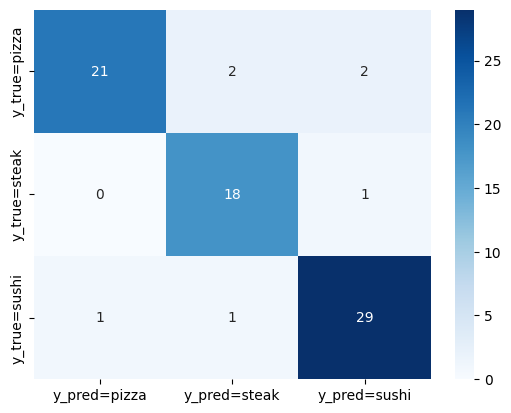

In [ ]:
confmat = ConfusionMatrix(task='multiclass', num_classes=3)
confusion_matrix = confmat(test_preds, test_labels)
showmatrix(confusion_matrix)